<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/Face2Gene_VGG_face_10_W%26B_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Class and samples
'''

Angelman:     205
Williams:     231
FragileX:     163
CDL:  250
TreacherCollins:      103
Apert:        200
Down: 197
Progeria:     150
Charge: 178
Noonan: 154
BWS: 211

'''

'\n\nAngelman:     205\nWilliams:     231\nFragileX:     163\nCDL:  250\nTreacherCollins:      103\nApert:        200\nDown: 197\nProgeria:     150\nCharge: 178\nNoonan: 154\nBWS: 211\n\n'

In [ ]:
!pip install keras_applications
!pip install keras_vggface
!pip install tensorflow-addons

In [ ]:
!nvidia-smi

Fri Jun 11 12:46:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: aayushktyagi (use `wandb login --relogin` to force relogin)


True

In [ ]:
import numpy as np 
import sys 
import os 
import time 
import cv2 
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [ ]:
# #Tensorflow utilities
# import tensorflow as tf
# import tensorflow_addons as tfa
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.models import Model , load_model, Sequential
# from tensorflow.keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.applications import NASNetLarge
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from keras_vggface.vggface import VGGFace
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
#keras
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model , load_model, Sequential
from keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
# from keras.applications import ResNet50
# from keras.applications import DenseNet121
# from keras.applications import NASNetLarge
# from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras_vggface.vggface import VGGFace
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)


In [ ]:
# base data path 
train_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/train'
val_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/val'
test_path = '/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Dataset/Face2Gene_10_split/test'

In [ ]:
# parameters
image_size = 224
train_batch_size = 32
val_batch_size = 32
model_name = 'VGG_Face'  # ResNet50/DenseNet

In [ ]:
# loading data

def load_dataset():

    train_datagen = ImageDataGenerator(rescale = 1/255.,
                                       rotation_range = 10,
                                      #  width_shift_range = 0.10,
                                      #  height_shift_range = 0.1,
                                      #  zoom_range=0.10, 
                                       horizontal_flip = True
                                      )

    valid_datagen = ImageDataGenerator(rescale = 1/255.)

    test_datagen = ImageDataGenerator(rescale = 1/255.)


    train_generator = train_datagen.flow_from_directory(
            train_path,
            target_size=(image_size, image_size),
            batch_size= train_batch_size,
            class_mode='categorical',
            shuffle=True)

    validation_generator = valid_datagen.flow_from_directory(
        val_path,
        target_size=(image_size, image_size),
        batch_size= val_batch_size,
        class_mode='categorical',
        shuffle=True)

    test_generator = test_datagen.flow_from_directory(
                test_path,
                target_size = (image_size, image_size),
                batch_size = 1,
                class_mode = 'categorical',
                shuffle = False)
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_dataset()


train_num_classes = len(train_generator.class_indices)
val_num_classes = len(validation_generator.class_indices)
test_num_classes = len(test_generator.class_indices)

Found 1499 images belonging to 10 classes.
Found 185 images belonging to 10 classes.
Found 194 images belonging to 10 classes.


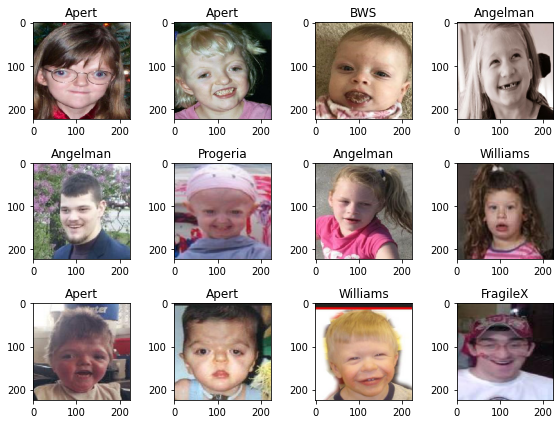

In [ ]:
# Visualize images

def display_images_sample(images, labels, class_list ,columns=4,rows=3):
    fig = plt.figure(figsize=(2*columns,2*rows))

    for i in range(columns*rows):
        fig.add_subplot(rows,columns,i+1)
        img = images[i]
        image_id = np.argmax(labels[i])
        class_label = class_list[image_id]
        plt.title(class_label)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

class_list = list(train_generator.class_indices.keys())
images , labels = next(validation_generator)
display_images_sample(images, labels, class_list)

In [ ]:
# loading data

def load_dataset(config):

    train_datagen = ImageDataGenerator(rescale = 1/255.,
                                       rotation_range = 10,
                                      #  width_shift_range = 0.10,
                                      #  height_shift_range = 0.1,
                                      #  zoom_range=0.10, 
                                       horizontal_flip = True
                                      )

    valid_datagen = ImageDataGenerator(rescale = 1/255.)

    test_datagen = ImageDataGenerator(rescale = 1/255.)


    train_generator = train_datagen.flow_from_directory(
            train_path,
            target_size=(image_size, image_size),
            batch_size= config.batch_size,
            class_mode='categorical',
            shuffle=True)

    validation_generator = valid_datagen.flow_from_directory(
        val_path,
        target_size=(image_size, image_size),
        batch_size= config.val_batch_size,
        class_mode='categorical',
        shuffle=True)

    test_generator = test_datagen.flow_from_directory(
                test_path,
                target_size = (image_size, image_size),
                batch_size = 1,
                class_mode = 'categorical',
                shuffle = False)
    
    return train_generator, validation_generator, test_generator

# train_generator, validation_generator, test_generator = load_dataset()


# train_num_classes = len(train_generator.class_indices)
# val_num_classes = len(validation_generator.class_indices)
# test_num_classes = len(test_generator.class_indices)

In [ ]:
# Load model 
def load_model(config, model_name = 'VGG_Face'):
    if model_name == 'ResNet50':
        img = Input(shape=(image_size,image_size,3))
        base_model = ResNet50(include_top = False,
                              weights= 'imagenet',
                              input_tensor=img,
                              pooling='avg',
                              input_shape = None)

        final_layer = base_model.layers[-1].output
        final_layer = Dropout(0.2)(final_layer)
        dense_layer1 = Dense(512, activation='relu')(final_layer)
        dense_layer1 = Dropout(0.2)(dense_layer1)
        # dense_layer1 = BatchNormalization()(dense_layer1)
        dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
        dense_layer2 = Dropout(0.2)(dense_layer2)
        dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
        output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

        model = Model(img,output_layer)
        for layer in base_model.layers:
            layer.trainable = False

        model.summary()
        
    if model_name == 'VGG_Face':
        img = Input(shape=(image_size,image_size,3))
        base_model = VGGFace(model='resnet50', include_top=False, input_shape=None, input_tensor= img)

        final_layer = base_model.get_layer('avg_pool').output
        final_layer = Flatten()(final_layer)
        # final_layer = Dropout(0.2)(final_layer)
        dense_layer1 = Dense(512, activation='relu')(final_layer)
        dense_layer1 = BatchNormalization()(dense_layer1)
        dense_layer1 = Dropout(config.dropout)(dense_layer1)
        dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
        dense_layer1 = BatchNormalization()(dense_layer1)
        dense_layer2 = Dropout(config.dropout)(dense_layer2)
        dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
        dense_layer1 = BatchNormalization()(dense_layer1)
        output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

        model = Model(img,output_layer)
        for layer in base_model.layers:
            layer.trainable = True

        model.summary()
        
    if model_name == 'DenseNet':
        img = Input(shape=(image_size,image_size,3))
        base_model = DenseNet121(include_top = False,
                              weights= 'imagenet',
                              input_tensor=img,
                              pooling='avg',
                              input_shape = None)

        final_layer = base_model.layers[-1].output
        final_layer = Dropout(0.2)(final_layer)
        dense_layer1 = Dense(512, activation='relu')(final_layer)
        dense_layer1 = Dropout(0.2)(dense_layer1)
        dense_layer1 = BatchNormalization()(dense_layer1)
        dense_layer2 = Dense(256,activation= 'relu')(dense_layer1)
        dense_layer2 = Dropout(0.2)(dense_layer2)
        dense_layer3 = Dense(128,activation= 'relu')(dense_layer2)
        output_layer = Dense(train_num_classes,activation='softmax')(dense_layer3)

        model = Model(img,output_layer)
        for layer in base_model.layers:
            layer.trainable = False

        model.summary()
        
    return model

In [ ]:
def train():
    wandb.init(project='Face2Gene',
               config={
                "learning_rate": 0.01,
                "Tags":"10_Class",
                "epochs": 200,
                "dropout": random.uniform(0.01, 0.80),
                "batch_size": 64,
                "loss_function": "categorical_crossentropy",
                "architecture": "VGG_Face",
                "dataset": "Face2Gene",
                "val_batch_size":8
               })
    config = wandb.config
    
    # Load dataset
    train_generator, validation_generator, test_generator = load_dataset(config)
    
    #load model
    model = load_model(config,model_name = 'VGG_Face')
    
    # compile model like you usually do.
    # notice use of config.
    optimizer = tf.keras.optimizers.SGD(learning_rate = config.learning_rate)
    model.compile(optimizer, config.loss_function, metrics=['categorical_accuracy','Precision','Recall',tfa.metrics.F1Score(num_classes=train_num_classes, average='macro')])
    
    # Callback 
    callbacks = [
        EarlyStopping(patience=25, verbose=1,monitor='val_loss'),
        ReduceLROnPlateau(factor=0.05, patience=5, min_lr=0.000000001, verbose=1,monitor='val_loss'),
        # ModelCheckpoint('/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Models/VGG_face_ResNet_11_basemodel_sgd_lr01_hf_r10.h5', verbose=1, save_best_only=True, save_weights_only=True)
    ]
    
    # Train model
    
    fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch= np.ceil(len(train_generator) // config.batch_size),
        epochs = config.epochs,
        validation_data = validation_generator,
        validation_steps= np.ceil(len(validation_generator) // config.val_batch_size),
        callbacks= [callbacks,WandbCallback(save_model = False)]
        )
    
    scores = model.evaluate(test_generator,steps= len(test_generator),verbose = 1)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    # Add test results to W&B
    wandb.log({'Test Accuracy': scores[1]*100})
       

In [ ]:
len(train_generator)

47

In [ ]:
sweep_config = {
  'method': 'bayes', 
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 25
  },
  'parameters': {
      'batch_size': {
          'values': [8, 16, 32, 64]
      },
      'learning_rate':{
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
      }
  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Face2Gene")

Create sweep with ID: 0cusra47
Sweep URL: https://wandb.ai/aayushktyagi/Face2Gene/sweeps/0cusra47


In [ ]:
wandb.agent(sweep_id, function=train)

1/1 [==============================] - 2s 2s/step - loss: 3.2170 - categorical_accuracy: 0.0938 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0659 - val_loss: 2.2410 - val_categorical_accuracy: 0.2083 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0658
Epoch 29/200
1/1 [==============================] - 2s 2s/step - loss: 2.8432 - categorical_accuracy: 0.1250 - precision: 0.4000 - recall: 0.0625 - f1_score: 0.0675 - val_loss: 2.3965 - val_categorical_accuracy: 0.0833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0673
Epoch 30/200
1/1 [==============================] - 2s 2s/step - loss: 2.8462 - categorical_accuracy: 0.1250 - precision: 0.2500 - recall: 0.0312 - f1_score: 0.0672 - val_loss: 2.3066 - val_categorical_accuracy: 0.1250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0668

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-09.
Epoch 31/200
1/1 [==============================] - 2s 

epoch,34
loss,3.11905
categorical_accuracy,0.125
precision,0.16667
recall,0.03125
f1_score,0.06969
val_loss,2.36506
val_categorical_accuracy,0.0
val_precision,0.0
val_recall,0.0
val_f1_score,0.06916


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,▃▆▅▆▆▅▇▃█▃▂▅▅▅▂▇▆▇▆▆▅▅▆▇▁▆▄█▅▅▆▆▅▃▇
categorical_accuracy,▆▅▄▂▃▄▃▆▆▄▅▄▃▃▅▂▃▃▁▆▅▃▃▃█▅▆▃▄▄▃▃▃▆▄
precision,▁▁▄▃▃▃▁▃▆▆▃▃▁▄▇▁▁▁▁▆▁█▁▁▇▅▆▁▇▅▁▃▁▁▃
recall,▁▁▅▅▅▅▁▅██▅▅▁▅█▁▁▁▁▅▁▅▁▁█▅▅▁█▅▁▅▁▁▅
f1_score,█▄▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,█▂▄▅▅▃▅▂▁▁▆▃▆▇▃▄▃▃▂▅▄▂▆▆▄▇▂▂▇▄▅▃▃▄▆
val_categorical_accuracy,▃▄▃▄▇▃▄▅▆▇▃▄▅▂▆▄▅▆▇▃▃▇▃▃▅▄▇▆▃▄▄▅█▆▁
val_precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,█▅▃▁▁▁▁▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃


wandb: Agent Starting Run: tehf8nv1 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Found 1499 images belonging to 10 classes.
Found 185 images belonging to 10 classes.
Found 194 images belonging to 10 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           c

wandb: Ctrl + C detected. Stopping sweep.


NameError: ignored

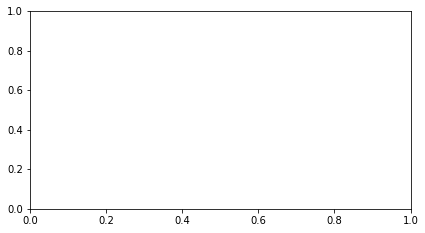

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['categorical_accuracy'])  
plt.plot(fit_history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
# Load model 
# model.load_weights('/content/drive/MyDrive/ColabNotebooks/Cancer/Face2Gene/Models/VGG_face_ResNet_8_basemodel_sgd_lr01_hf_r5_s10.h5')

In [ ]:
scores = model.evaluate(test_generator,steps= len(test_generator),verbose = 1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# Add test results to W&B
wandb.log({'Test Accuracy': scores[1]*100})

run.join()

In [ ]:
pred = model.predict(test_generator, steps = len(test_generator), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)

In [ ]:
# class wise 
def predict(test_generator, predicted_class_index):

    confusion_mat_score = confusion_matrix(test_generator,predicted_class_index)
    sns.heatmap(confusion_mat_score, annot=True)
    # sns.heatmap(results/np.sum(results), annot=True, fmt='.2%', cmap='Blues')
    # print(results)
    #Classification accuracy
    accuracy = accuracy_score(test_generator,predicted_class_index)
    print("Classification accuracy:{}".format(accuracy))
    print()
    print(accuracy)
    #Classification report 
    classify_report = classification_report(test_generator,predicted_class_index)
    print("Classification report")
    print(classify_report)

    return confusion_mat_score, accuracy, classify_report
    
confusion_mat_score, accuracy, classification_report = predict(test_generator.classes, predicted_class_indices)

In [ ]:
# Confusion matrix
df_cm = pd.DataFrame(confusion_mat_score, columns=class_list, index = class_list)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (9,7))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [ ]:
# Confusion matrix
cm_sum = np.sum(confusion_mat_score,axis=1, keepdims=True)
cm_perc = confusion_mat_score / cm_sum.astype(float) * 100
df_cm = pd.DataFrame(cm_perc, columns=class_list, index = class_list)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_list): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
test_generator.reset() # resetting generator
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)